In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 250
sns.set_style('darkgrid')

In [3]:
df = pd.read_excel('Airlines+Data.xlsx')

In [4]:
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [6]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [7]:
df.nunique()

Month         96
Passengers    80
dtype: int64

# Visualization

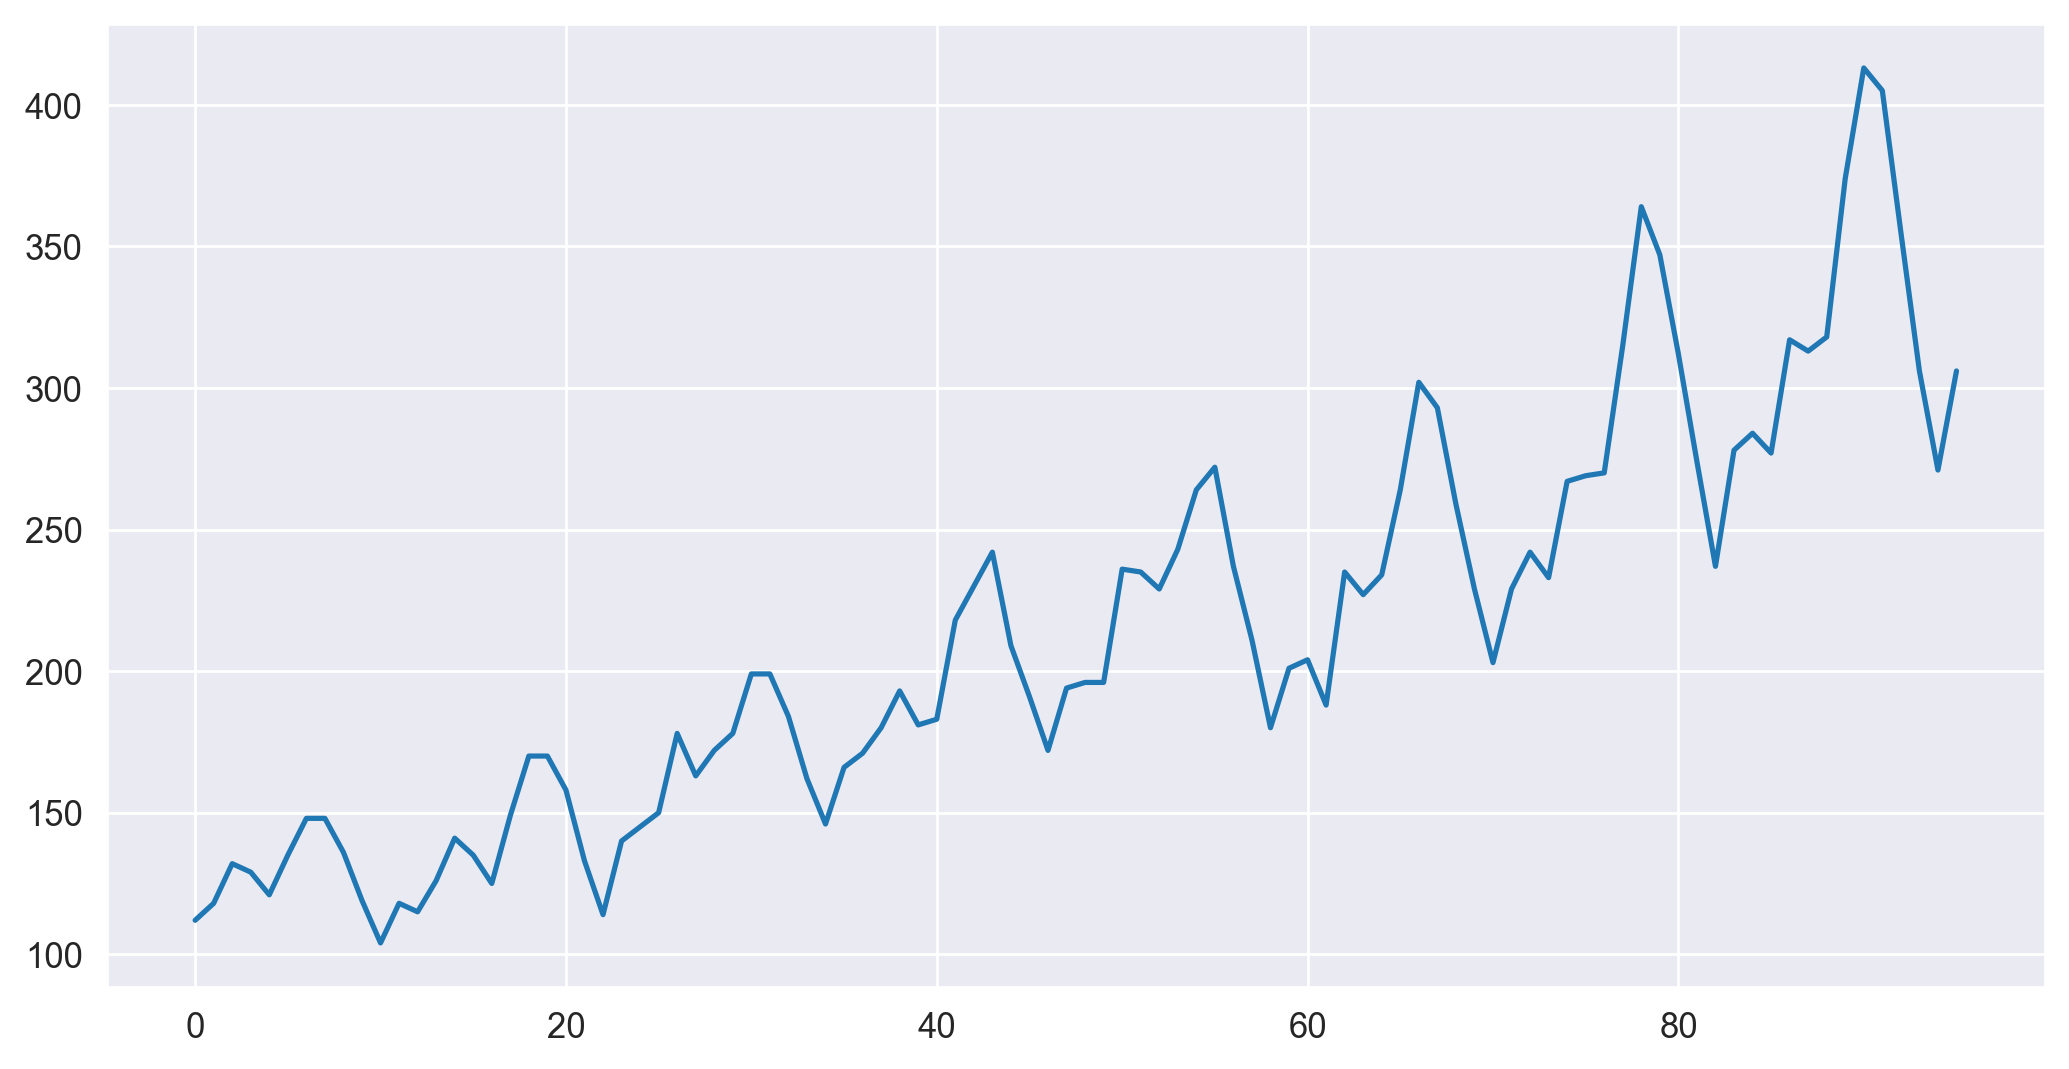

In [9]:
plt.plot(df['Passengers'])

<AxesSubplot:xlabel='Passengers', ylabel='Density'>

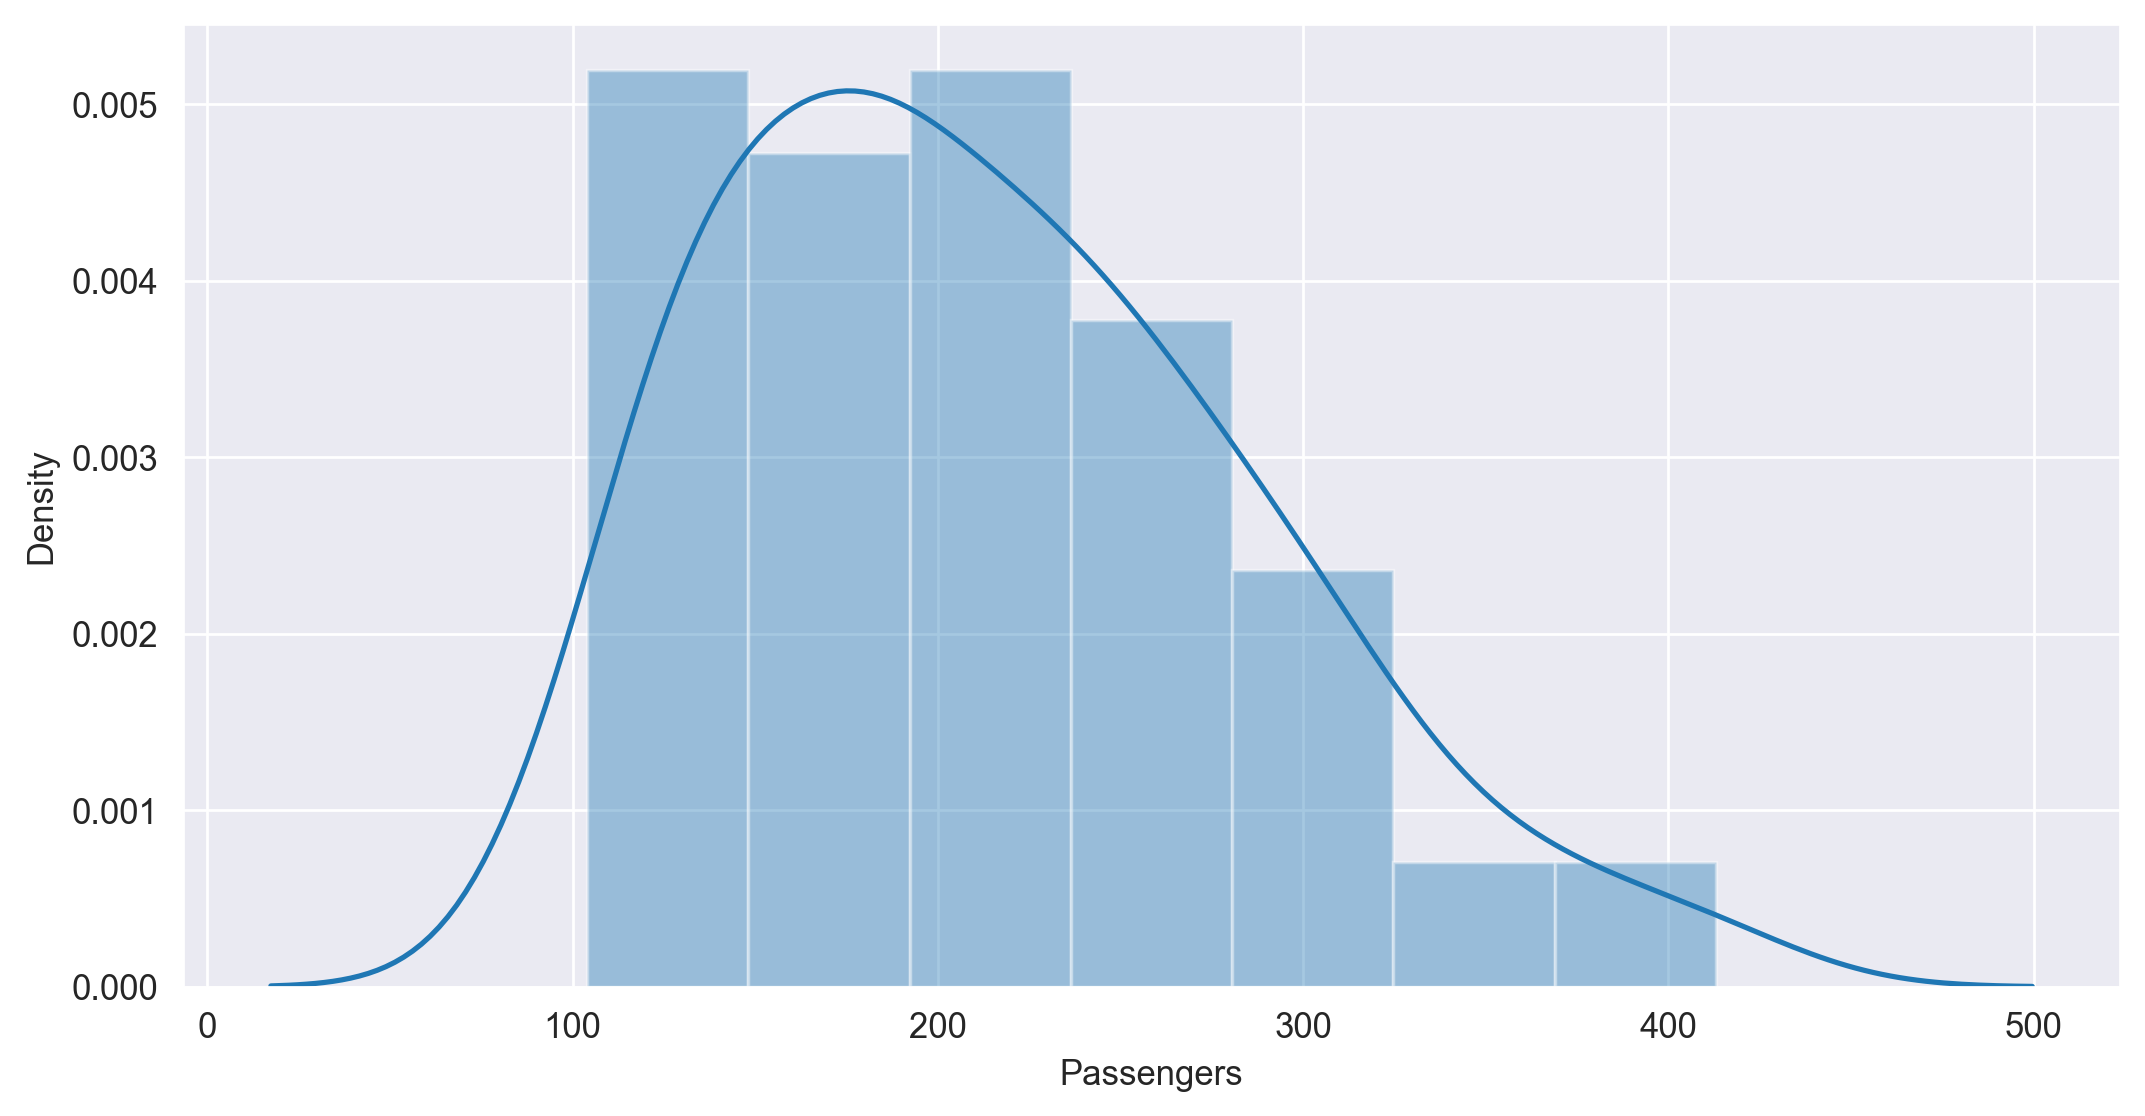

In [10]:
sns.distplot(df['Passengers'])

In [13]:
df1 = pd.read_excel('Airlines+Data.xlsx',header=0,index_col=0,parse_dates=True,squeeze=True)

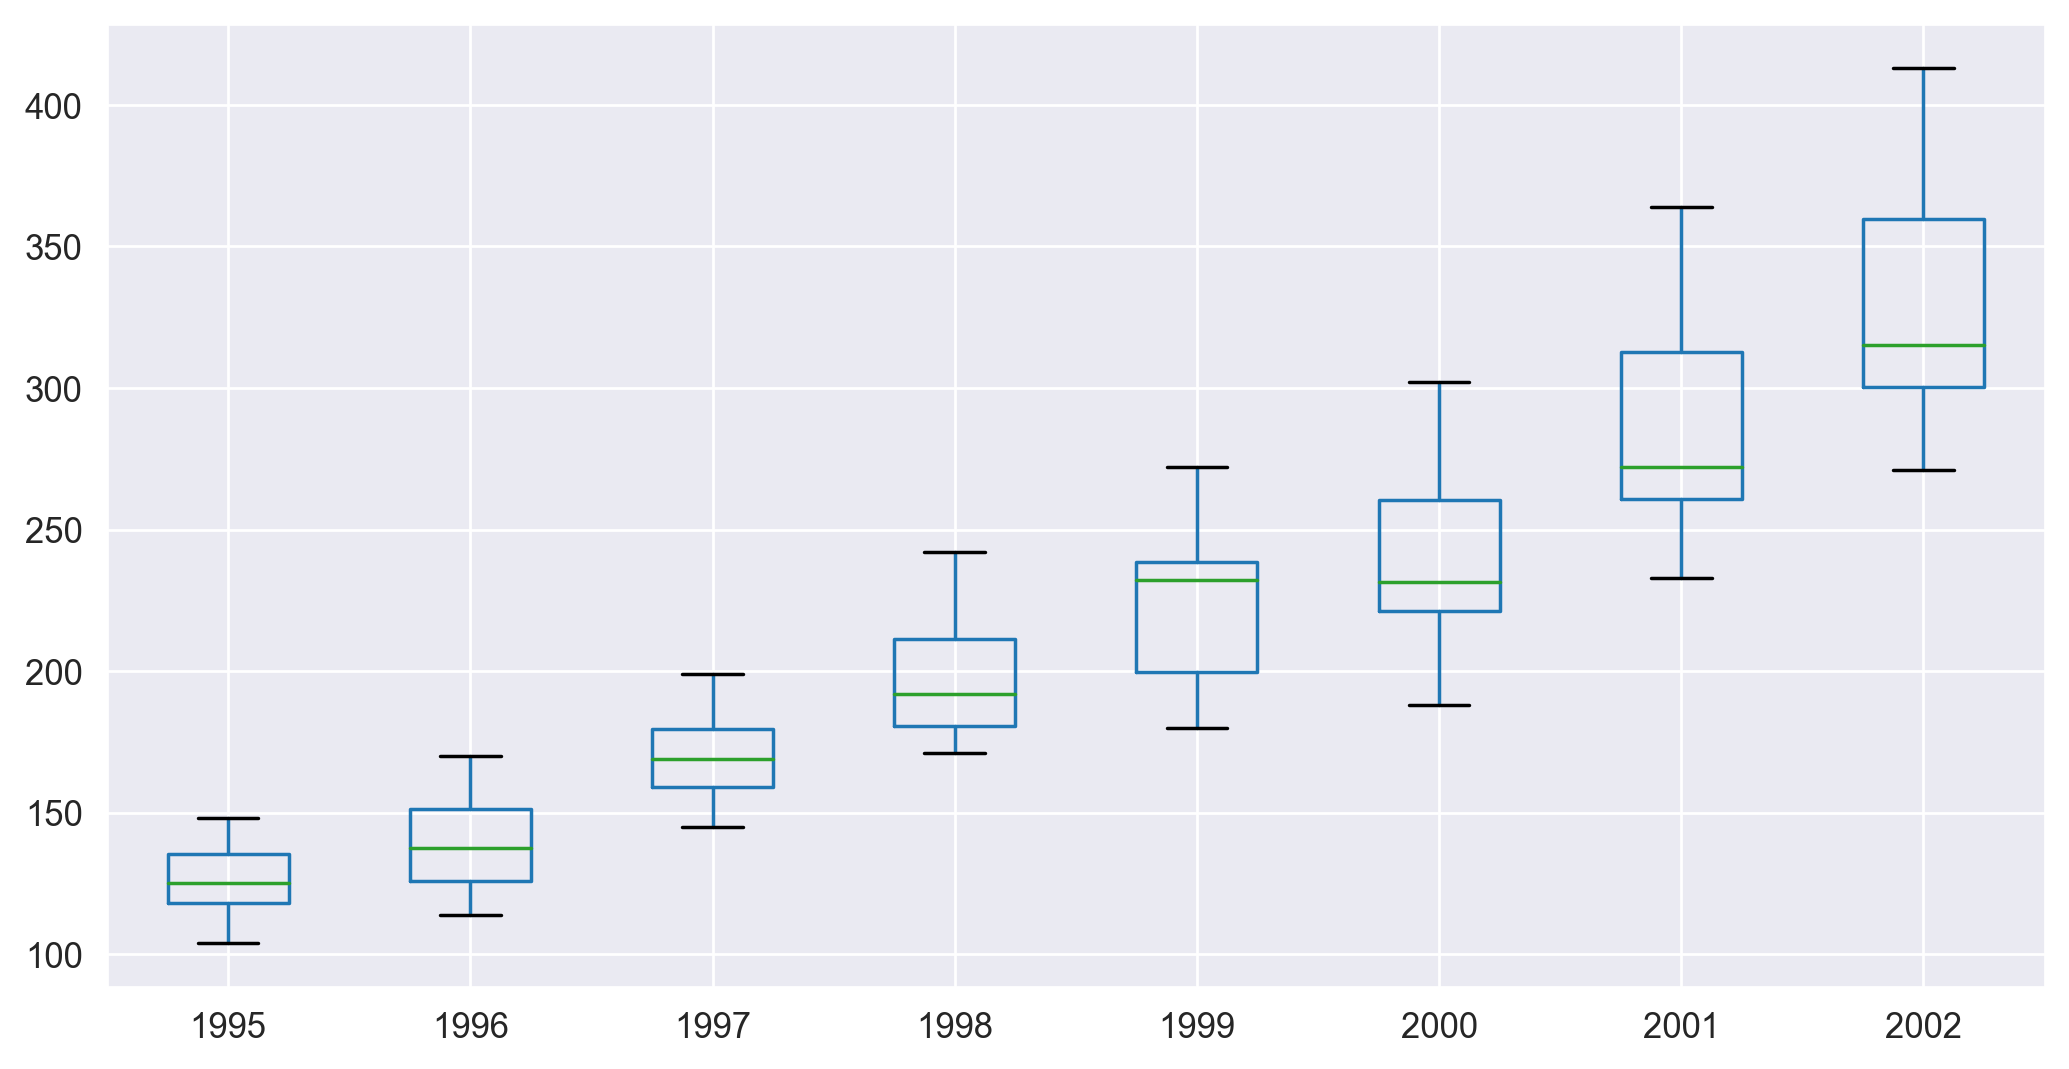

In [14]:
group=df1.groupby(pd.Grouper(freq='A'))
years=pd.DataFrame()
for i,j in group:
    years[i.year]=j.values
years.boxplot()
plt.show()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

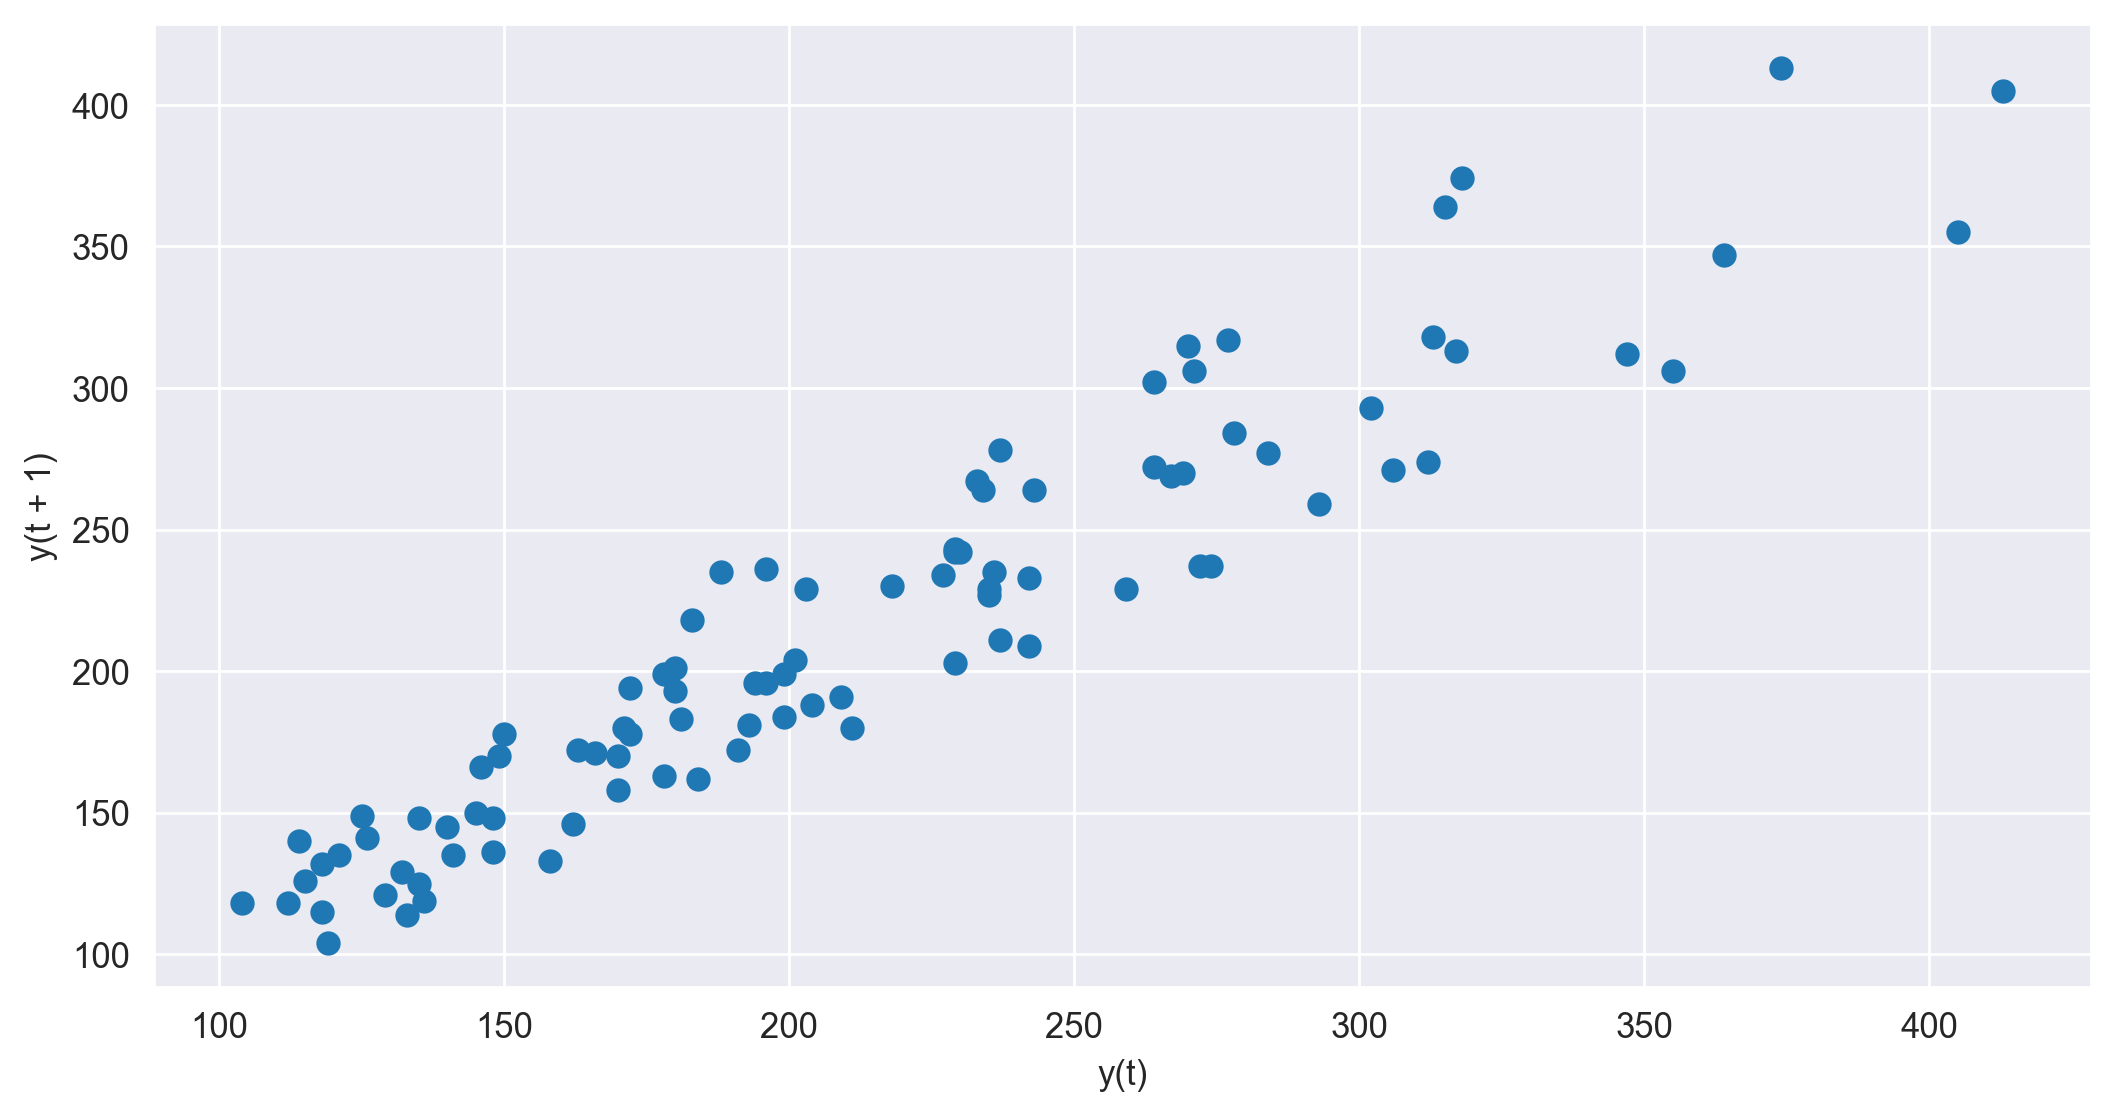

In [15]:
lag_plot(df1)

In [16]:
df.rename({'Month':'Date'}, axis=1, inplace=True)

In [17]:
# Splitting Data training and Testing

In [18]:
train = df.head(77)
test = df.tail(19)

In [19]:
# Moving Average and time decomposition plot

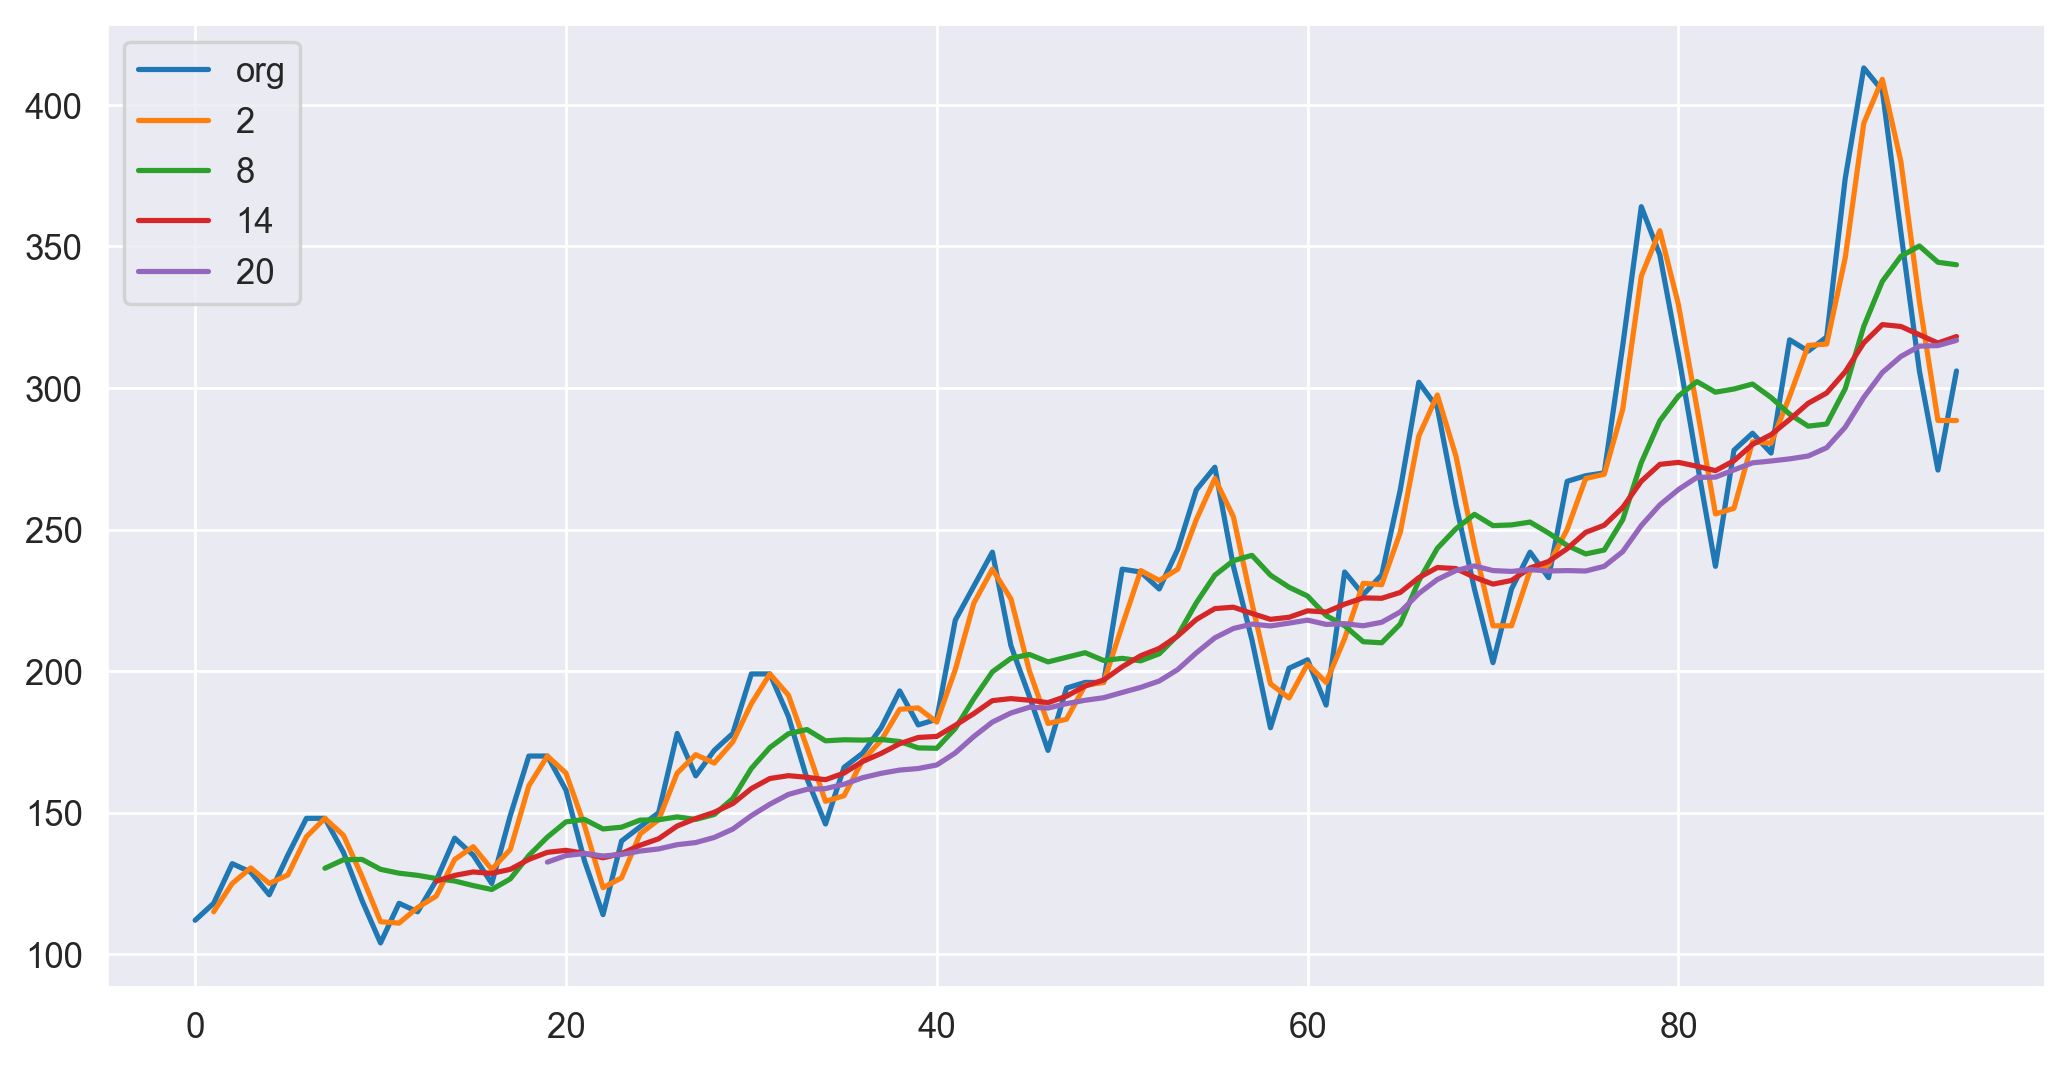

In [20]:
df.Passengers.plot(label="org")
for i in range(2,24,6):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

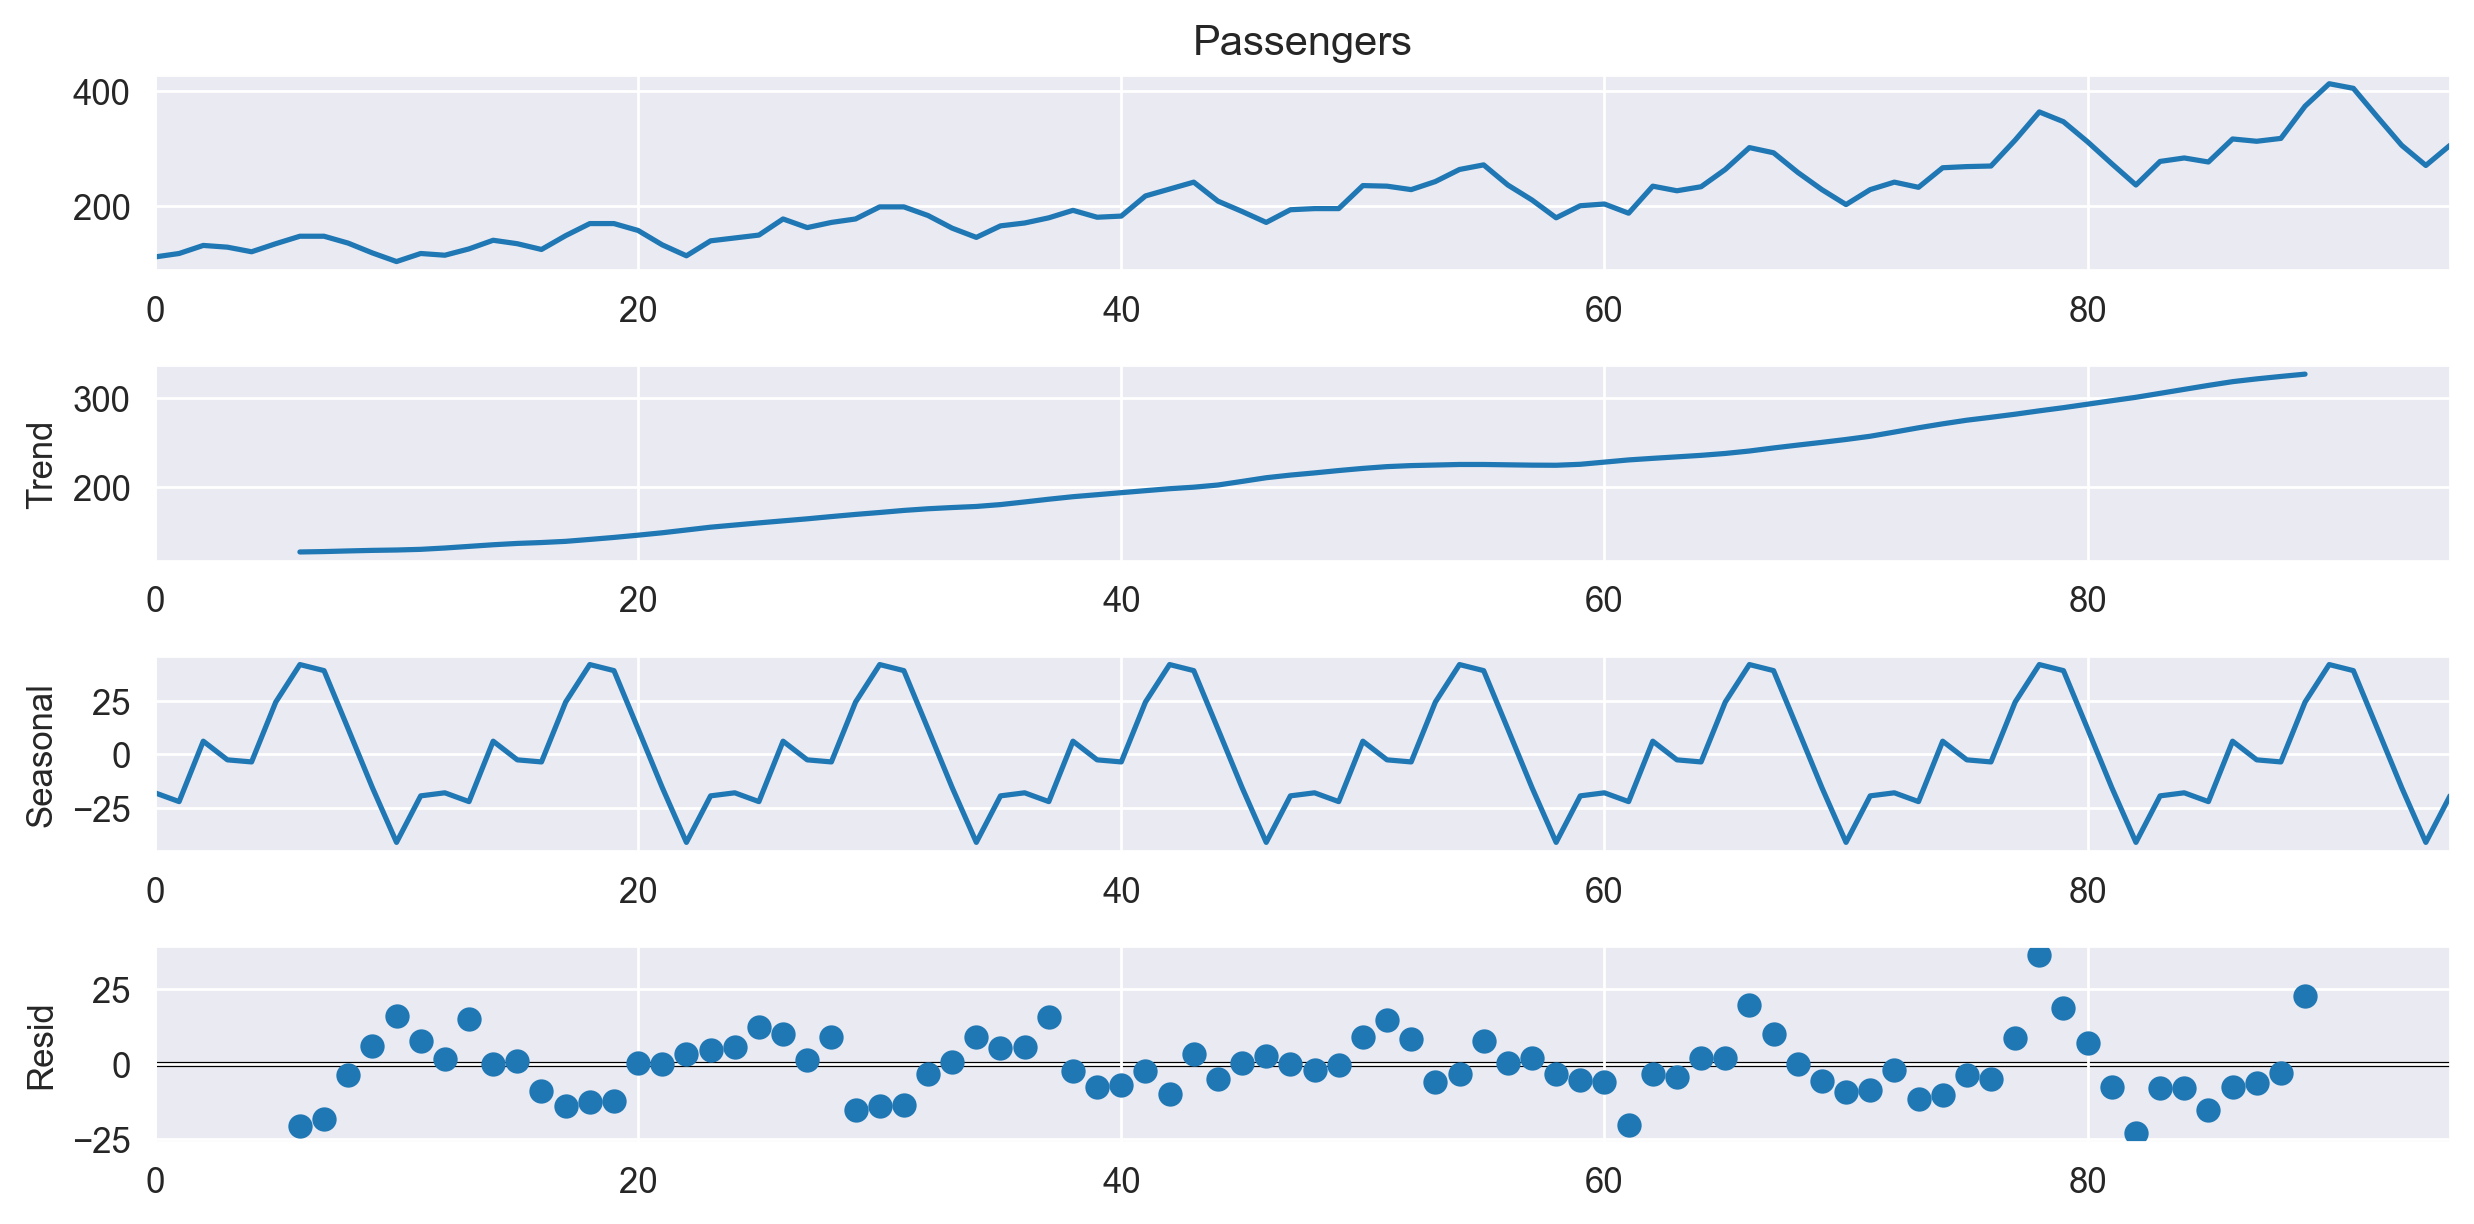

In [21]:
decompose_ts_add = seasonal_decompose(df.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

# ACF plots and PACF plots to identify the significant features that contribute to forecast

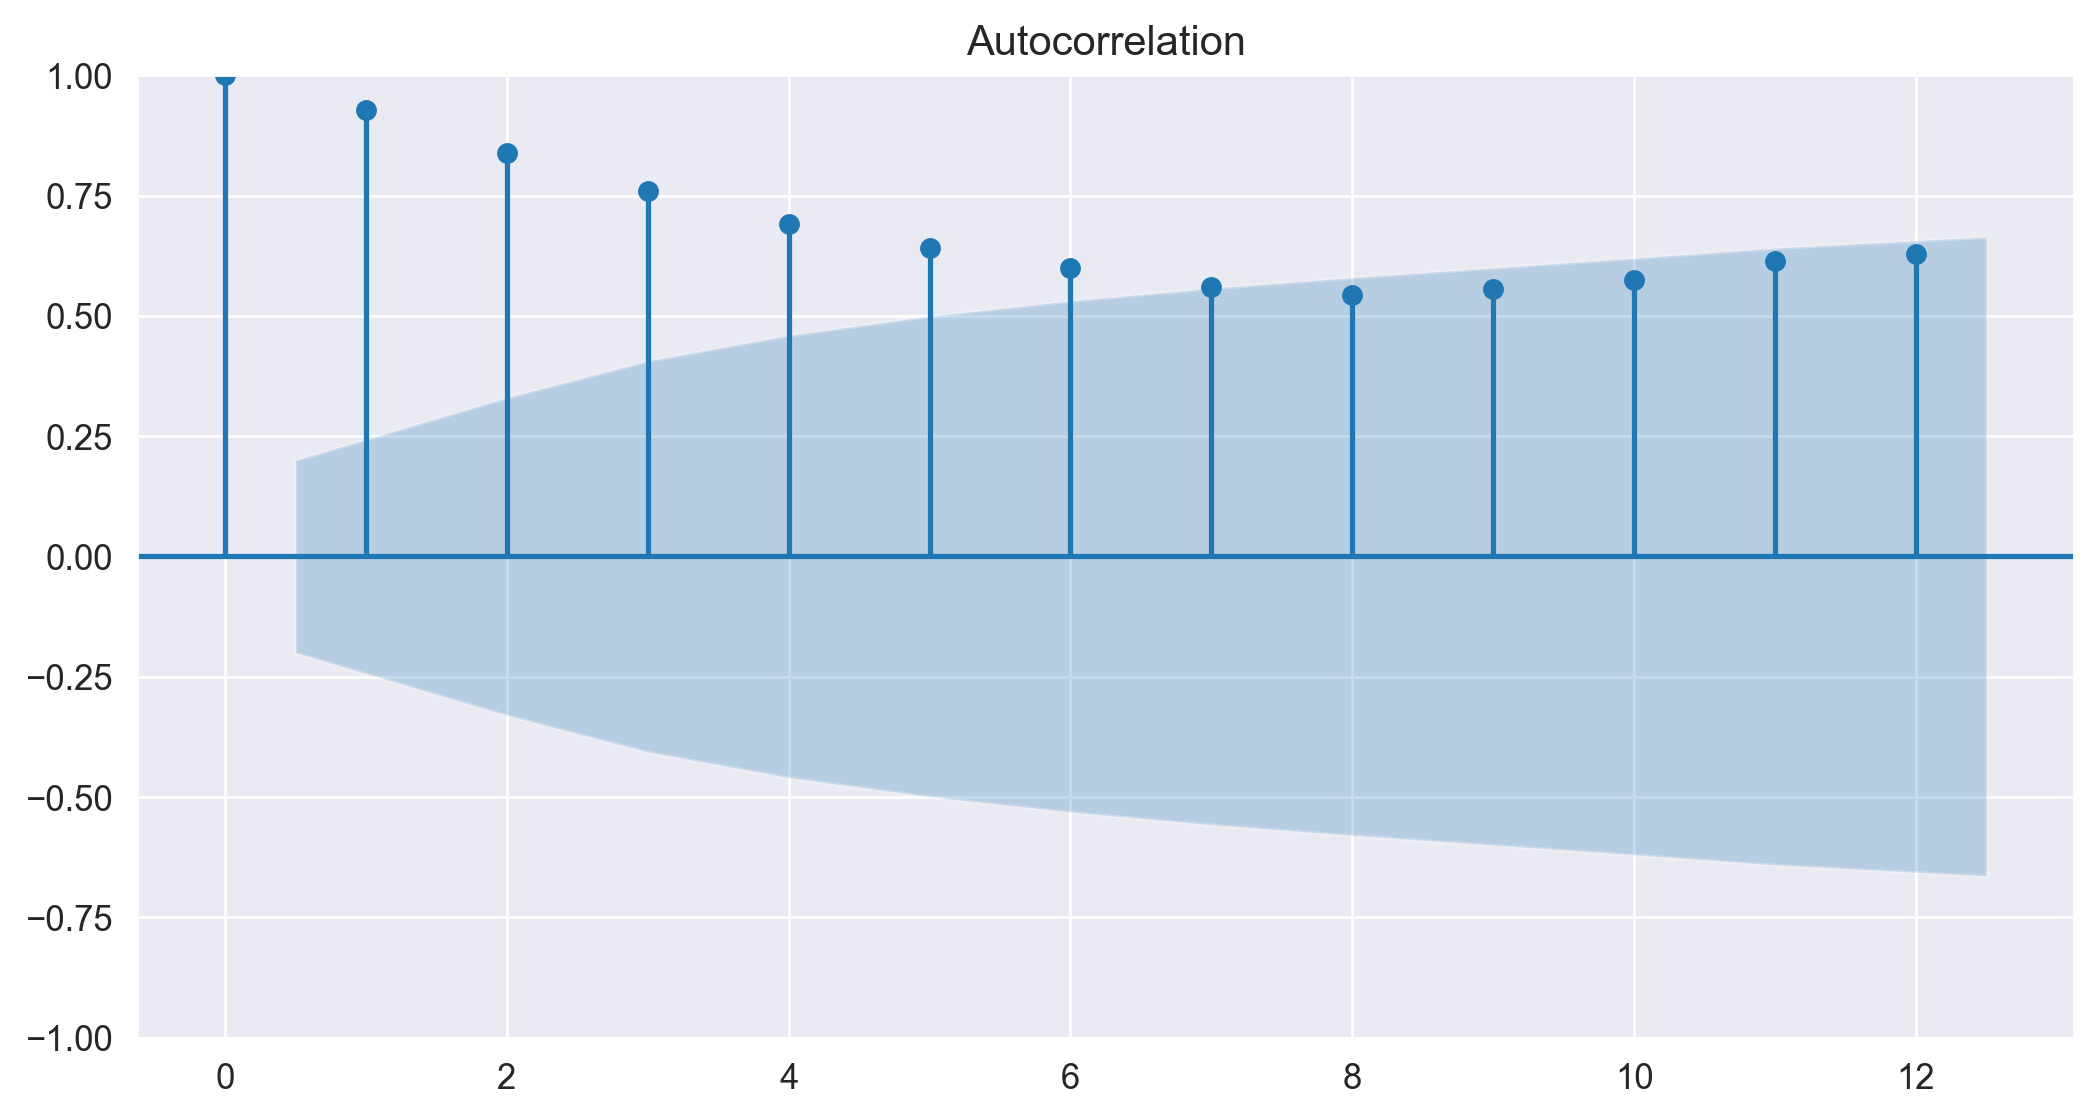

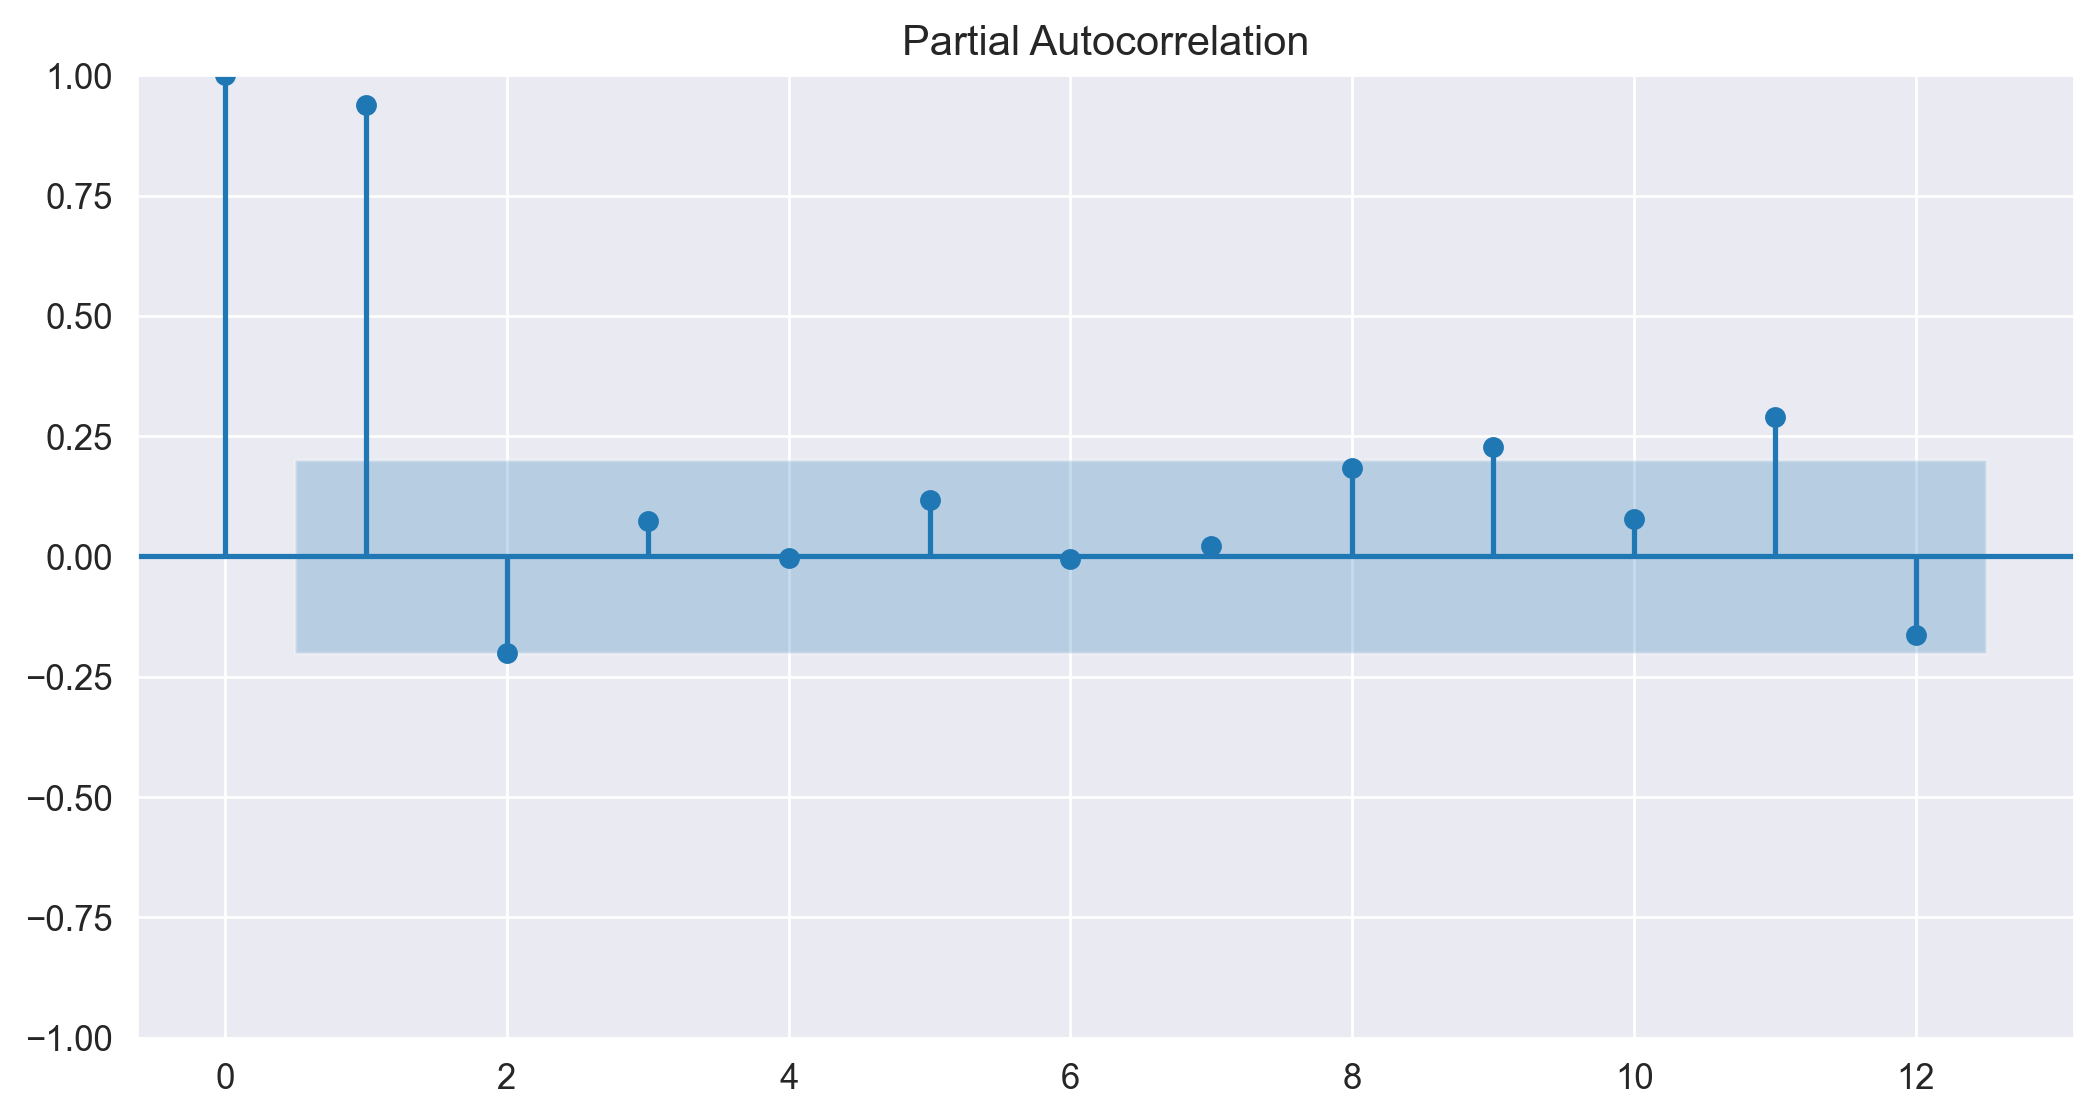

In [23]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(df.Passengers,lags=12)
tsa_plots.plot_pacf(df.Passengers,lags=12)
plt.show()

# Calculate RMSE value

In [25]:
def RMSE(pred,org):
    temp = (np.sqrt(np.mean((np.array(org)-np.array(pred))**2)))
    return temp

# Developing a data driven model - Simple exponential method

In [26]:
ses_model = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
r1=RMSE(pred_ses,test.Passengers) 
r1

80.54332901444305

# Developing a data driven model - Holt's model

In [28]:
hw_model = Holt(train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
r2=RMSE(pred_hw,test.Passengers) 
r2

47.877728640303836

# Developing a data driven model - Holts winter exponential smoothing with additive seasonality and additive trend

In [29]:
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
r3=RMSE(pred_hwe_add_add,test.Passengers) 
r3

35.902298336684105

# Developing a data driven model - Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [30]:
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
r4=RMSE(pred_hwe_mul_add,test.Passengers)
r4

30.905644200950647

- Consolidating the results

In [31]:
t={"model":pd.Series(['Simple exponential','Holts model','Holts-add seas,add trend','holts-mul sea,add trend']),
   "RMSE":[r1,r2,r3,r4]
  }

In [32]:
t=pd.DataFrame(t)
t

,model,RMSE
0,Simple exponential,80.543329
1,Holts model,47.877729
2,"Holts-add seas,add trend",35.902298
3,"holts-mul sea,add trend",30.905644


# Creating a final model, to predict on the combined train and test dataset

In [34]:
hwe_model_mul_add_new = ExponentialSmoothing(df["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit()

In [35]:
# Forecasting for next 10 time periods

In [36]:
hwe_model_mul_add_new.forecast(10)

96     312.899424
97     308.171306
98     355.532782
99     345.769814
100    345.696096
101    392.470733
102    436.501361
103    429.859243
104    380.172872
105    332.317301
dtype: float64